Classes and their corresponding labels:
Label 0: Class 'Not Sinkhole'
Label 1: Class 'Not Wormhole'
Label 2: Class 'Sinkhole'
Label 3: Class 'Wormhole'
Cross-Validation Accuracy Scores: [0.91114808 0.91321951 0.91094407 0.91037914 0.91408261]
Mean Cross-Validation Accuracy: 0.91
Confusion Matrix:
[[15874     0    44     0]
 [    0 14886     0  1045]
 [  323     0 15585     0]
 [    0  4132     0 11835]]
Accuracy: 0.91
Classification Report:
              precision    recall  f1-score   support

           0       0.98      1.00      0.99     15918
           1       0.78      0.93      0.85     15931
           2       1.00      0.98      0.99     15908
           3       0.92      0.74      0.82     15967

    accuracy                           0.91     63724
   macro avg       0.92      0.91      0.91     63724
weighted avg       0.92      0.91      0.91     63724



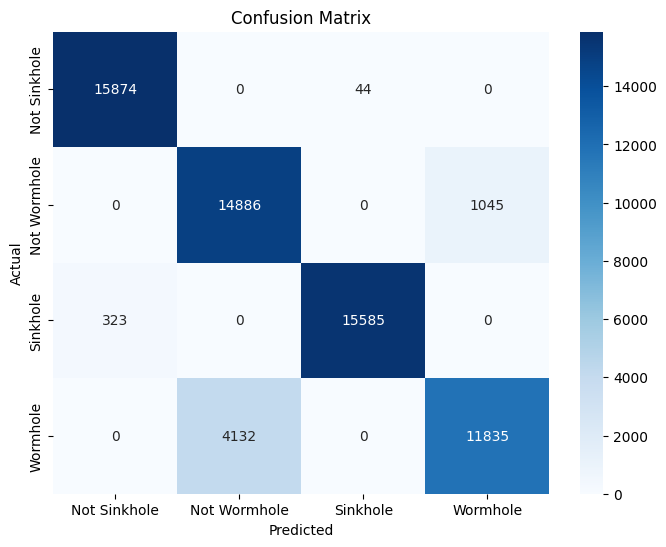

AUC for class Not Sinkhole: 1.00
AUC for class Not Wormhole: 0.95
AUC for class Sinkhole: 1.00
AUC for class Wormhole: 0.95
Micro-average AUC: 0.99


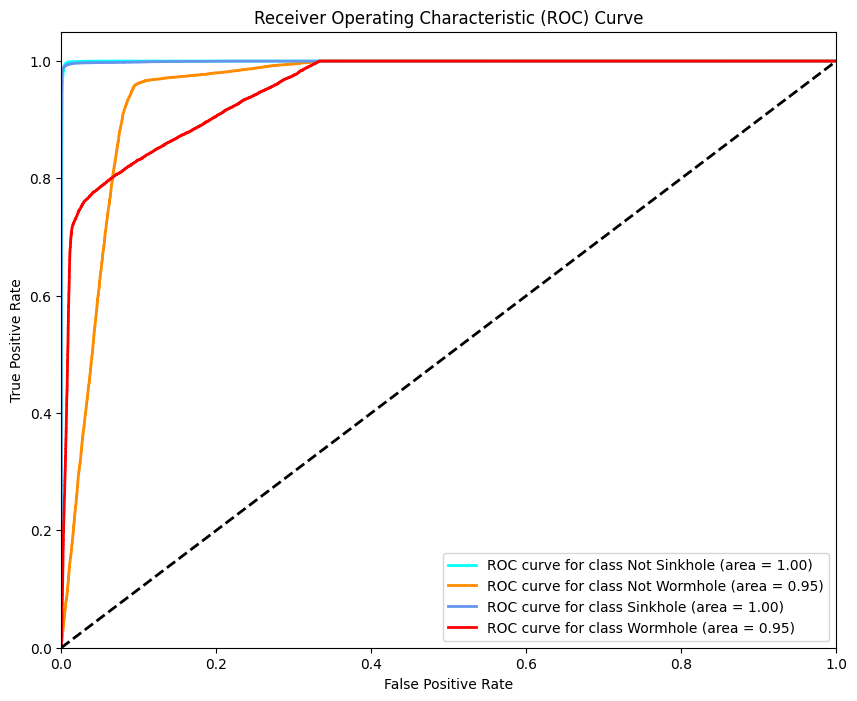

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.preprocessing import LabelEncoder, StandardScaler, label_binarize
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, roc_curve, auc
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
import xgboost as xgb
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.multiclass import OneVsRestClassifier
from itertools import cycle
import numpy as np

# Load the dataset
file_path = '/Users/nadellaujwala/Downloads/attack-final.csv'
data = pd.read_csv(file_path)

# Data Preprocessing
data['Timestamp'] = pd.to_datetime(data['Timestamp'], errors='coerce')
data = data.dropna(subset=['Timestamp'])  # Drop rows where timestamp couldn't be parsed
data['Hour'] = data['Timestamp'].dt.hour
data['Day'] = data['Timestamp'].dt.day
data['Month'] = data['Timestamp'].dt.month
data.drop(columns=['Timestamp'], inplace=True)  # Drop the original Timestamp column

# Encode IP addresses
le_source = LabelEncoder()
data['Source_IP'] = le_source.fit_transform(data['Source_IP'])

le_dest = LabelEncoder()
data['Destination_IP'] = le_dest.fit_transform(data['Destination_IP'])

# Normalize Packet_Size and other numerical features
scaler = StandardScaler()
data[['Packet_Size', 'Hour', 'Day', 'Month']] = scaler.fit_transform(data[['Packet_Size', 'Hour', 'Day', 'Month']])

# Encode Action
le_action = LabelEncoder()
data['Action'] = le_action.fit_transform(data['Action'])

# Encode target variable
le_wormhole = LabelEncoder()
data['Output'] = le_wormhole.fit_transform(data['Output'])

# Check the classes assigned to the labels
classes = le_wormhole.classes_
print("Classes and their corresponding labels:")
for label, cls in enumerate(classes):
    print(f"Label {label}: Class '{cls}'")

# Define features and target
X = data.drop(columns=['ID', 'Output'])
y = data['Output']

# Apply SMOTE to balance the dataset
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

# Initialize individual classifiers with best parameters

# Decision Tree Classifier with best parameters
dt_classifier = DecisionTreeClassifier(
    criterion='entropy', 
    max_depth=50, 
    min_samples_split=10, 
    min_samples_leaf=4,
    random_state=42
)

# XGBoost Classifier with best parameters
xgb_classifier = xgb.XGBClassifier(
    n_estimators=200, 
    max_depth=7, 
    learning_rate=0.1, 
    subsample=0.8, 
    colsample_bytree=0.8, 
    random_state=42
)

# Random Forest Classifier with best parameters
rf_classifier = RandomForestClassifier(
    n_estimators=100, 
    max_depth=10, 
    random_state=42
)

# Initialize the Voting Classifier
voting_classifier = VotingClassifier(
    estimators=[
        ('decision_tree', dt_classifier),
        ('xgboost', xgb_classifier),
        ('random_forest', rf_classifier)
    ],
    voting='soft',  # Use 'soft' voting for probabilistic predictions
    weights=[1, 2, 2]  # Adjust weights as per the performance of each classifier
)

# Perform Cross-Validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cross_val_scores = cross_val_score(voting_classifier, X_resampled, y_resampled, cv=cv, scoring='accuracy')
print(f'Cross-Validation Accuracy Scores: {cross_val_scores}')
print(f'Mean Cross-Validation Accuracy: {np.mean(cross_val_scores):.2f}')

# Train the Voting Classifier
voting_classifier.fit(X_train, y_train)

# Make predictions on the test set
y_pred = voting_classifier.predict(X_test)

# Print Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print('Confusion Matrix:')
print(conf_matrix)

# Print Accuracy and Classification Report
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.2f}')
print('Classification Report:')
print(classification_report(y_test, y_pred))

# Plot Confusion Matrix with Colors
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
            xticklabels=classes, yticklabels=classes)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Binarize the output labels for ROC curve
y_test_binarized = label_binarize(y_test, classes=[0, 1, 2, 3])
n_classes = y_test_binarized.shape[1]

# OneVsRestClassifier for ROC Curve
classifier = OneVsRestClassifier(voting_classifier)
y_score = classifier.fit(X_train, y_train).predict_proba(X_test)

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_binarized[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    print(f"AUC for class {classes[i]}: {roc_auc[i]:.2f}")

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test_binarized.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
print(f"Micro-average AUC: {roc_auc['micro']:.2f}")

# Plot ROC curve
plt.figure(figsize=(10, 8))
colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'red'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f'ROC curve for class {classes[i]} (area = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()
